# analyze_fit_us_data.ipynb

Analyze the curves that [fit_us_data.ipynb](./fit_us_data.ipynb) fit to the COVID-19 time series.

Inputs:
* `outputs/us_counties_curves.csv`: Curves generated by [fit_us_data.ipynb](./fit_us_data.ipynb)
* `outputs/us_counties_curves_meta.json`: Column type metadata for reading `data/us_counties_curves.csv` with `pd.read_csv()`
* `outputs/us_counties_curves_params.csv`: Model parameters corresponding to the curves in `data/us_counties_curves.csv`

**Note:** You can redirect these input files by setting the environment variable `COVID_OUTPUTS_DIR` to a replacement for the prefix `outputs` in the above paths.

In [1]:
# Initialization boilerplate
import os
import json
import pandas as pd
import numpy as np
from sklearn import metrics

# Local file of utility functions
import util

# Allow environment variables to override data file locations.
_OUTPUTS_DIR = os.getenv("COVID_OUTPUTS_DIR", "outputs")
util.ensure_dir_exists(_OUTPUTS_DIR)  # create if necessary

# Read and reformat input data

## Load the time series data

In [2]:
csv_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves.csv")
meta_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves_meta.json")

# Read column type metadata
with open(meta_file) as f:
    curves_meta = json.load(f)

# Pandas does not currently support parsing datetime64 from CSV files.
# As a workaround, read the "Date" column as objects and manually 
# convert after.
curves_meta["Date"] = "object"

curves_vertical = (
    pd
    .read_csv(csv_file, dtype=curves_meta, parse_dates=["Date"])   
    .set_index(["FIPS", "Date"], verify_integrity=True)
)
curves_vertical

State   County  Population  Confirmed_7_Days  \
FIPS  Date                                                         
1001  2020-03-10  Alabama  Autauga       55869               124   
      2020-03-11  Alabama  Autauga       55869               124   
      2020-03-12  Alabama  Autauga       55869               124   
      2020-03-13  Alabama  Autauga       55869               124   
      2020-03-14  Alabama  Autauga       55869               124   
...                   ...      ...         ...               ...   
56045 2022-02-16  Wyoming   Weston        6927                 8   
      2022-02-17  Wyoming   Weston        6927                 8   
      2022-02-18  Wyoming   Weston        6927                 8   
      2022-02-19  Wyoming   Weston        6927                 8   
      2022-02-20  Wyoming   Weston        6927                 8   

                  Deaths_7_Days  Confirmed  Confirmed_Outlier  Exponential  \
FIPS  Date                                                                   
1001  2020-03-10              8          0              False     1.000000   
      2020-03-11              8          0              False     1.001001   
      2020-03-12              8          0              False     1.002002   
      2020-03-13              8          0              False     1.003005   
      2020-03-14              8          0              False     1.004008   
...                         ...        ...                ...          ...   
56045 2022-02-16              0       1530              False     2.029927   
      2022-02-17              0       1531              False     2.031958   
      2022-02-18              0       1532              False     2.033991   
      2022-02-19              0       1532              False     2.036026   
      2022-02-20              0       1532              False     2.038063   

                     Logistic    Logistic2  
FIPS  Date                                  
1001  2020-03-10   624.633189   611.620967  
      2020-03-11   628.671073   613.486337  
      2020-03-12   632.733923   615.374811  
      2020-03-13   636.821882   617.286631  
      2020-03-14   640.935088   619.222041  
...                       ...          ...  
56045 2022-02-16  1392.323000  1397.087344  
      2022-02-17  1394.800644  1399.646948  
      2022-02-18  1397.272091  1402.200724  
      2022-02-19  1399.737319  1404.748648  
      2022-02-20  1402.196306  1407.290695  

[2227412 rows x 10 columns]

In [3]:
# Name of the column that bgfs.ipynb analyzed
ts_col_name = "Confirmed"
outlier_col_name = ts_col_name + "_Outlier"
metadata_cols = ["State", "County", "Population"]

In [4]:
# As a workaround for a bug in Pandas' extension types system,
# we need to cast the boolean columns to ints.
curves_vertical[outlier_col_name] = curves_vertical[outlier_col_name].astype(np.int8)
curves_vertical

State   County  Population  Confirmed_7_Days  \
FIPS  Date                                                         
1001  2020-03-10  Alabama  Autauga       55869               124   
      2020-03-11  Alabama  Autauga       55869               124   
      2020-03-12  Alabama  Autauga       55869               124   
      2020-03-13  Alabama  Autauga       55869               124   
      2020-03-14  Alabama  Autauga       55869               124   
...                   ...      ...         ...               ...   
56045 2022-02-16  Wyoming   Weston        6927                 8   
      2022-02-17  Wyoming   Weston        6927                 8   
      2022-02-18  Wyoming   Weston        6927                 8   
      2022-02-19  Wyoming   Weston        6927                 8   
      2022-02-20  Wyoming   Weston        6927                 8   

                  Deaths_7_Days  Confirmed  Confirmed_Outlier  Exponential  \
FIPS  Date                                                                   
1001  2020-03-10              8          0                  0     1.000000   
      2020-03-11              8          0                  0     1.001001   
      2020-03-12              8          0                  0     1.002002   
      2020-03-13              8          0                  0     1.003005   
      2020-03-14              8          0                  0     1.004008   
...                         ...        ...                ...          ...   
56045 2022-02-16              0       1530                  0     2.029927   
      2022-02-17              0       1531                  0     2.031958   
      2022-02-18              0       1532                  0     2.033991   
      2022-02-19              0       1532                  0     2.036026   
      2022-02-20              0       1532                  0     2.038063   

                     Logistic    Logistic2  
FIPS  Date                                  
1001  2020-03-10   624.633189   611.620967  
      2020-03-11   628.671073   613.486337  
      2020-03-12   632.733923   615.374811  
      2020-03-13   636.821882   617.286631  
      2020-03-14   640.935088   619.222041  
...                       ...          ...  
56045 2022-02-16  1392.323000  1397.087344  
      2022-02-17  1394.800644  1399.646948  
      2022-02-18  1397.272091  1402.200724  
      2022-02-19  1399.737319  1404.748648  
      2022-02-20  1402.196306  1407.290695  

[2227412 rows x 10 columns]

## Collapse each time series down to a single cell

This kind of time series data is easier to manipulate at the macroscopic level if each time series occupies a 
single cell of the DataFrame. We use the [TensorArray](https://text-extensions-for-pandas.readthedocs.io/en/latest/#text_extensions_for_pandas.TensorArray) Pandas extension type from [Text Extensions for Pandas](https://github.com/CODAIT/text-extensions-for-pandas).

In [5]:
curves, dates = util.collapse_time_series(curves_vertical, [
    ts_col_name, outlier_col_name,
    "Exponential", "Logistic", "Logistic2"])
curves

,State,County,Population,Confirmed_7_Days,Deaths_7_Days,Confirmed,Confirmed_Outlier,Exponential,Logistic,Logistic2
FIPS,,,,,,,,,,
1001,Alabama,Autauga,55869,124,8,"[ 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ 1.0, 1.0010005001667084, 1.002...","[ 624.6331894752971, 628.6710725690872, 632....","[ 611.6209674664152, 613.4863366928142, 615...."
1003,Alabama,Baldwin,223234,319,9,"[ 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ 1.0, 1.0010005001667084, 1.002...","[2060.7612874244896, 2073.158727058375, 2085...","[1804.2584408744247, 1816.1456369827201, 1828..."
1005,Alabama,Barbour,24686,20,3,"[ 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ 1.0, 1.0010005001667084, 1.002...","[1379.0803011728278, 1381.8282813341245, 1384....","[ 282.2759570824437, 283.68114620977803, 285...."
1007,Alabama,Bibb,22394,40,2,"[ 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ 1.0, 1.0010005001667084, 1.002...","[290.18903826648176, 291.8275900300823, 293.4...","[ 295.6151496504065, 297.10579106132735, 298.6..."
1009,Alabama,Blount,57826,116,3,"[ 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ 1.0, 1.0010005001667084, 1.002...","[ 595.9804081930149, 599.8802336825881, 603....","[164.62408247212932, 164.6646400715394, 164.7..."
...,...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,120,3,"[ 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ 1.0, 1.0010005001667084, 1.002...","[ 2589.560912294687, 2594.633492819649, 2599...","[431.93541728442926, 432.6363961292781, 433...."
56039,Wyoming,Teton,23464,114,0,"[ 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ 1.0, 1.0010005001667084, 1.002...","[2078.6093593566143, 2082.709182211988, 2086....","[500.99717144243004, 503.4595647822046, 505...."
56041,Wyoming,Uinta,20226,30,0,"[ 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ 1.0, 1.0010005001667084, 1.002...","[220.80062528373784, 222.07899021650772, 223.3...","[349.57866453859987, 350.7172917108218, 351...."


## Load the parameters of the curves that `fit_us_data.ipynb` fit

In [6]:
params_data_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves_params.csv")
params = pd.read_csv(params_data_file).set_index("FIPS", verify_integrity=True)
params

,State,County,Population,Confirmed_7_Days,Deaths_7_Days,Exp_Rate,Exp_Offset,Log_Max,Log_Rate,Log_Offset,Log2_Max1,Log2_Rate1,Log2_Offset1,Log2_Max2,Log2_Rate2,Log2_Offset2,Log2_Switch_Begin,Log2_Switch_End
FIPS,,,,,,,,,,,,,,,,,,
1001,Alabama,Autauga,55869,124,8,0.001,0.000000e+00,15179.713386,0.006721,468.457363,987.876708,0.000000,7.710577,15913.608256,0.008568,261.268712,4.154896e+02,620.310606
1003,Alabama,Baldwin,223234,319,9,0.001,0.000000e+00,68013.984324,0.006186,560.283844,1256.197249,0.333574,175.942400,87773.004970,0.005892,515.197260,1.147566e+02,697.932161
1005,Alabama,Barbour,24686,20,3,0.001,0.000000e+00,2770.948678,0.003967,2.326799,764.872875,0.048021,195.885464,12191.283651,0.004235,709.476249,1.535955e+01,565.389535
1007,Alabama,Bibb,22394,40,2,0.001,0.000000e+00,7724.076583,0.005851,554.305266,941.978628,0.201391,267.594324,15293.994241,0.004501,712.999999,3.591289e-06,713.000000
1009,Alabama,Blount,57826,116,3,0.001,0.000000e+00,15085.899997,0.006791,469.858542,346.737471,0.000000,31.548526,17461.780921,0.030568,198.613055,5.162883e+02,713.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,120,3,0.001,0.000000e+00,5220.855522,0.003887,4.113539,984.190634,0.000000,28.932259,13629.048656,0.006375,562.737207,1.908834e-07,77.411895
56039,Wyoming,Teton,23464,114,0,0.001,0.000000e+00,4184.771657,0.003919,3.360202,973.292071,0.007752,49.628179,21915.907695,0.004985,713.000000,3.958240e+00,710.221965
56041,Wyoming,Uinta,20226,30,0,0.001,0.000000e+00,7384.003627,0.005951,584.638181,988.611704,0.004711,33.203244,7566.244902,0.006279,546.655389,1.502862e+01,360.753536


## Calculate goodness of fit

Create a dataframe of R^2 (coefficient of determination) values to measure how well each curve fit each series.

In [7]:
def compute_r_squared(colname):
    return [
        metrics.r2_score(
            curves.loc[fips][ts_col_name], curves.loc[fips][colname])
            for fips in curves.index
    ]

stats = curves[metadata_cols].copy()
stats["Exp_R^2"] = compute_r_squared("Exponential")
stats["Log_R^2"] = compute_r_squared("Logistic")
stats["Log2_R^2"] = compute_r_squared("Logistic2")
stats

,State,County,Population,Exp_R^2,Log_R^2,Log2_R^2
FIPS,,,,,,
1001,Alabama,Autauga,55869,-1.755806,0.955842,0.957884
1003,Alabama,Baldwin,223234,-1.514923,0.964800,0.967192
1005,Alabama,Barbour,24686,-1.939701,0.404174,0.967786
1007,Alabama,Bibb,22394,-1.656816,0.952957,0.967176
1009,Alabama,Blount,57826,-1.707772,0.957291,0.977985
...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,-1.333452,0.341197,0.961343
56039,Wyoming,Teton,23464,-1.435824,0.343352,0.909722
56041,Wyoming,Uinta,20226,-1.476400,0.955486,0.947094


In [8]:
# Compute some summary statistics of our summary statistics
stats[["Exp_R^2", "Log_R^2", "Log2_R^2"]].describe()

,Exp_R^2,Log_R^2,Log2_R^2
count,3124.000000,3124.000000,3124.000000
mean,-1.549194,0.851784,0.927146
std,0.403693,0.205188,0.109959
min,-5.935262,0.100696,0.104447
25%,-1.744749,0.910827,0.929503
50%,-1.529711,0.938878,0.951786
75%,-1.318450,0.953834,0.970369
max,0.184403,0.990222,0.999118


In [9]:
# Based on the stats above, it looks like R^2 >= 0.99 is a useful cutoff
# for "the curve fits the data"
r2_thresh = 0.99

# Let's see how many counties fit our curves at least that well.
print(f"""\
 Exp_R^2: {(stats['Exp_R^2'] >= r2_thresh).sum()} of {len(stats.index)} counties have R^2 >= {r2_thresh}
 Log_R^2: {(stats['Log_R^2'] >= r2_thresh).sum()} of {len(stats.index)} counties have R^2 >= {r2_thresh}
Log2_R^2: {(stats['Log2_R^2'] >= r2_thresh).sum()} of {len(stats.index)} counties have R^2 >= {r2_thresh}
"""
)

 Exp_R^2: 0 of 3124 counties have R^2 >= 0.99
 Log_R^2: 2 of 3124 counties have R^2 >= 0.99
Log2_R^2: 233 of 3124 counties have R^2 >= 0.99



# Break down time series according to curve characteristics

The R^2 metrics divide the time series into several groups. Let's look at examples of each of these groups in turn.

## Time series that can be explained by an exponential growth model

Identify time series for which a single exponential curve has R^2 above 0.99

In [10]:
util.graph_examples(curves, ts_col_name, {"Exponential": curves["Exponential"]},
                    mask=stats['Exp_R^2'] >= r2_thresh)

Nothing to plot


## Time series that are better explained by logistic growth

Let's look at some examples where logistic growth (with a single
instance of the logistic function) produces a good fit, while an
exponential growth model does not.

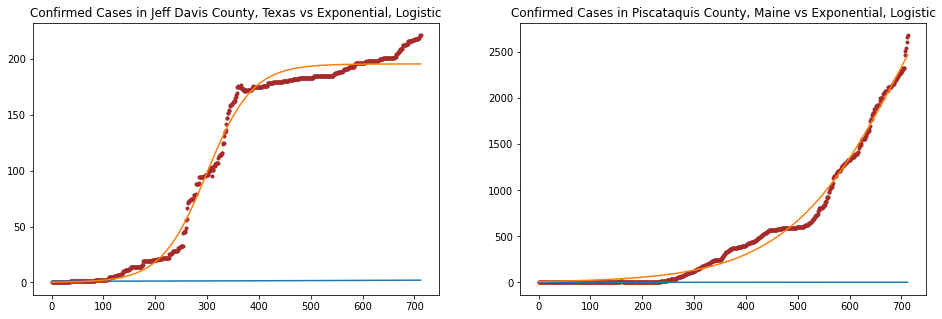

In [11]:
mask = (stats['Log_R^2'] >= r2_thresh) & (stats['Exp_R^2'] < 0.95)
util.graph_examples(curves, ts_col_name, 
                    {"Exponential": curves["Exponential"],
                     "Logistic": curves["Logistic"]},
                    mask=mask)

## Time series that are better explained by dual logistic functions

Let's examine cases where a mixture of two logistic growth models explains
the data better than a single logistic growth model.

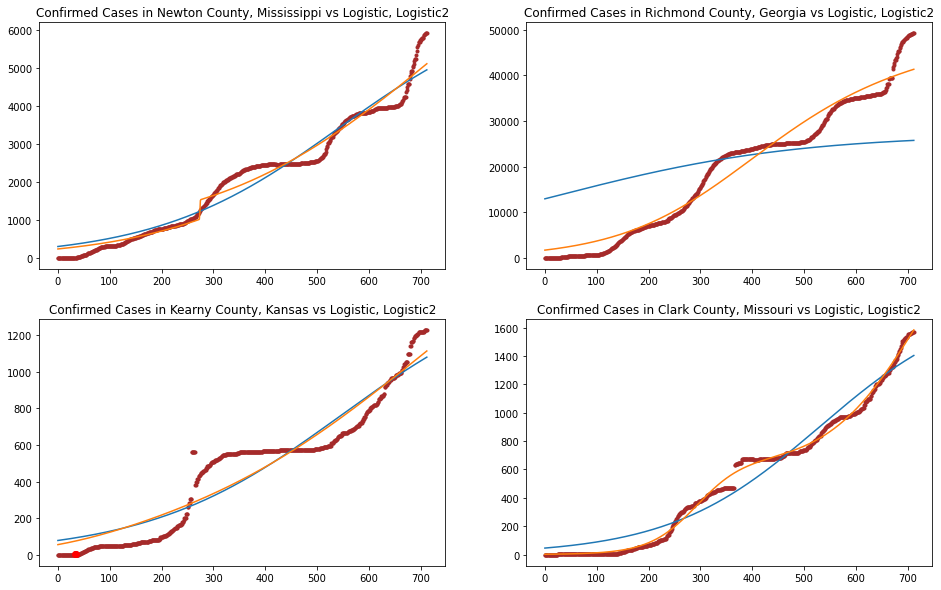

In [12]:
mask = stats['Log2_R^2'] - stats['Log_R^2'] >= 0.01
#graph_examples(mask, {"Logistic": logistic, "Logistic2": logistic2}, num_to_pick=10)
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=mask)

## Time series where recent data looks like a straight line

Many of the dual-logistic curves have low values for the rate of the
second logistic function, indicating a curve where the later parts of the
curve look more like a straight line. 
Across the entire data set, what models have logistic rate2 near zero?

In [13]:
small_rate2_mask = (stats['Log2_R^2'] >= r2_thresh) & (params["Log2_Rate2"] < 5e-2)
params[small_rate2_mask][metadata_cols + [c for c in params.columns if c.startswith("Log2")]]

,State,County,Population,Log2_Max1,Log2_Rate1,Log2_Offset1,Log2_Max2,Log2_Rate2,Log2_Offset2,Log2_Switch_Begin,Log2_Switch_End
FIPS,,,,,,,,,,,
6003,California,Alpine,1129,120.487324,10.000000,713.000000,237.915395,0.001982,713.000000,246.183380,258.242065
8117,Colorado,Summit,31011,4086.835610,0.018352,297.990939,25513.495892,0.000000,713.000000,676.739216,709.222452
13049,Georgia,Charlton,13392,951.424938,0.031951,219.705522,3632.799860,0.004785,506.235484,136.495131,149.942253
13053,Georgia,Chattahoochee,10907,2215.624634,0.035045,164.127703,8586.546609,0.034991,325.144229,556.464973,712.912148
13111,Georgia,Fannin,26188,2648.274425,0.018660,272.021420,7575.426269,0.007803,555.948638,570.419517,712.999989
...,...,...,...,...,...,...,...,...,...,...,...
55073,Wisconsin,Marathon,135692,40977.322936,0.032664,260.924124,55936.468522,0.017356,668.577374,110.283990,713.000000
55075,Wisconsin,Marinette,40350,7294.982107,0.030706,249.786580,27380.015094,0.010415,712.518759,449.555768,712.955584
55077,Wisconsin,Marquette,15574,1825.788651,0.036985,242.631701,8800.400064,0.008486,700.961563,549.373310,708.921630


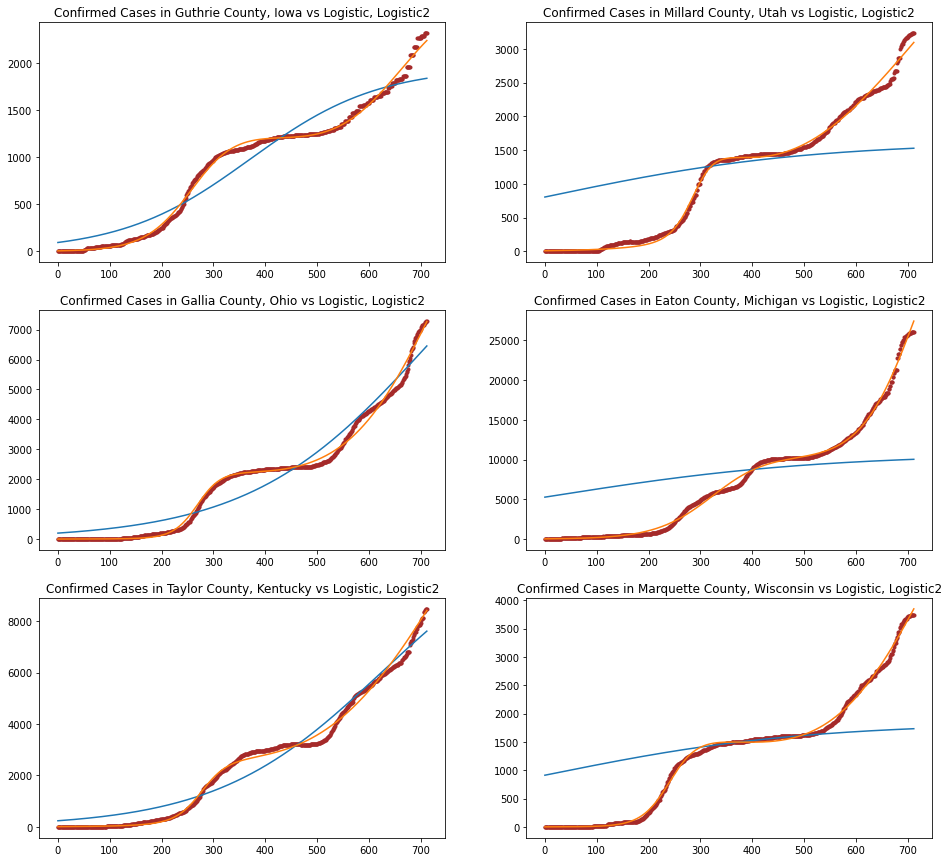

In [14]:
# Show some examples of these cases where Rate2 is small
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=small_rate2_mask,
                    num_to_pick=6)

## Time series that can explained by steep logistic growth

Look at counties for which the rate for the single-logistic-curve fit is large. 
A high rate corresponds to a "steep" instance of the logistic function that 
transisitions abruptly between different regimes.

In [15]:
large_rate_mask = (
    (stats['Log_R^2'] >= r2_thresh) 
    & (params["Log_Rate"] > 2e-1))
params[large_rate_mask][metadata_cols + [c for c in params.columns 
                                         if (c.startswith("Log")
                                             and not c.startswith("Log2"))]]

,State,County,Population,Log_Max,Log_Rate,Log_Offset
FIPS,,,,,,


In [16]:
# Show some examples of these cases where Rate is large
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=large_rate_mask,
                    num_to_pick=10)

Nothing to plot


## Time series that appear to be in the early phases of logistic growth

In [17]:
early_mask = (
    (stats['Log_R^2'] >= r2_thresh) & (params["Log_Offset"] > 80))
params[early_mask][metadata_cols + [c for c in params.columns 
                                    if (c.startswith("Log") and not c.startswith("Log2"))]]

,State,County,Population,Log_Max,Log_Rate,Log_Offset
FIPS,,,,,,
23021,Maine,Piscataquis,16785,4954.832506,0.008694,713.000000
48243,Texas,Jeff Davis,2274,195.445973,0.022770,299.359981


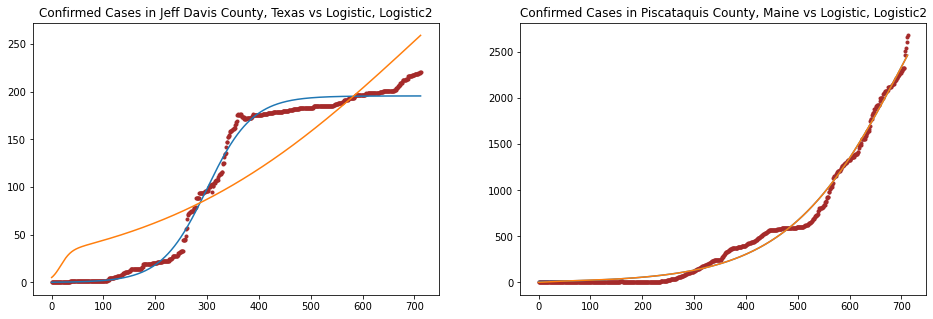

In [18]:
# Graphs of counties for which the logistic curve fit is currently
# in the early phases of logistic growth
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=early_mask,
                    num_to_pick=10)

## Time series for counties with high population

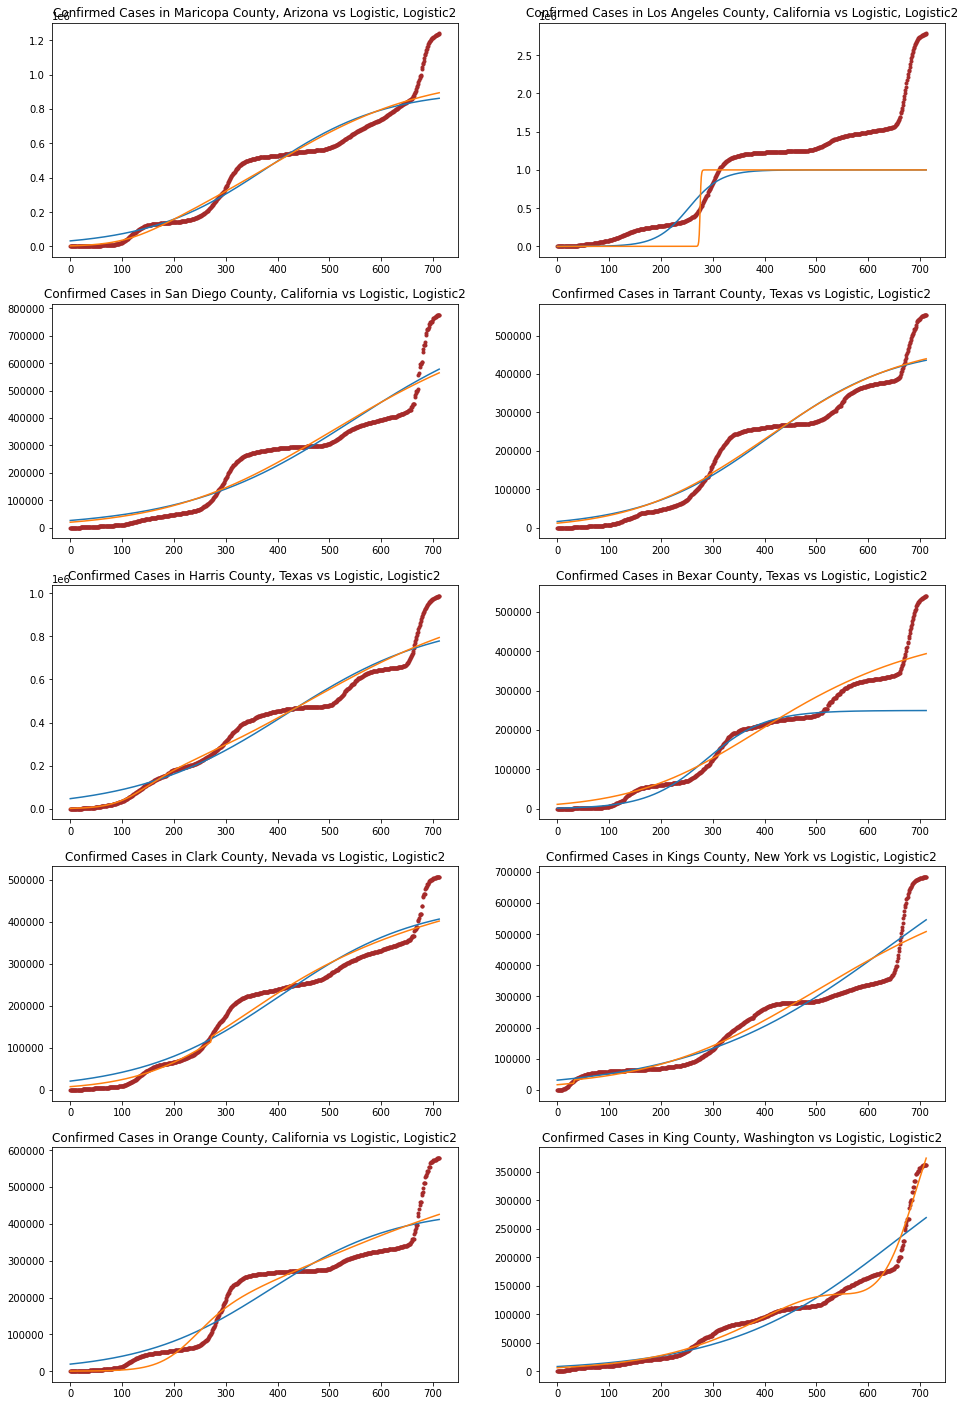

In [19]:
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=curves["Population"] > 2e6,
                    num_to_pick=10)

## Time series that  *not* explained by any of our curves

In [20]:
non_fitting_mask = (stats["Exp_R^2"] < 0.99) & (stats["Log_R^2"] < 0.99) & (stats["Log2_R^2"] < 0.99)
stats[non_fitting_mask]

,State,County,Population,Exp_R^2,Log_R^2,Log2_R^2
FIPS,,,,,,
1001,Alabama,Autauga,55869,-1.755806,0.955842,0.957884
1003,Alabama,Baldwin,223234,-1.514923,0.964800,0.967192
1005,Alabama,Barbour,24686,-1.939701,0.404174,0.967786
1007,Alabama,Bibb,22394,-1.656816,0.952957,0.967176
1009,Alabama,Blount,57826,-1.707772,0.957291,0.977985
...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,-1.333452,0.341197,0.961343
56039,Wyoming,Teton,23464,-1.435824,0.343352,0.909722
56041,Wyoming,Uinta,20226,-1.476400,0.955486,0.947094


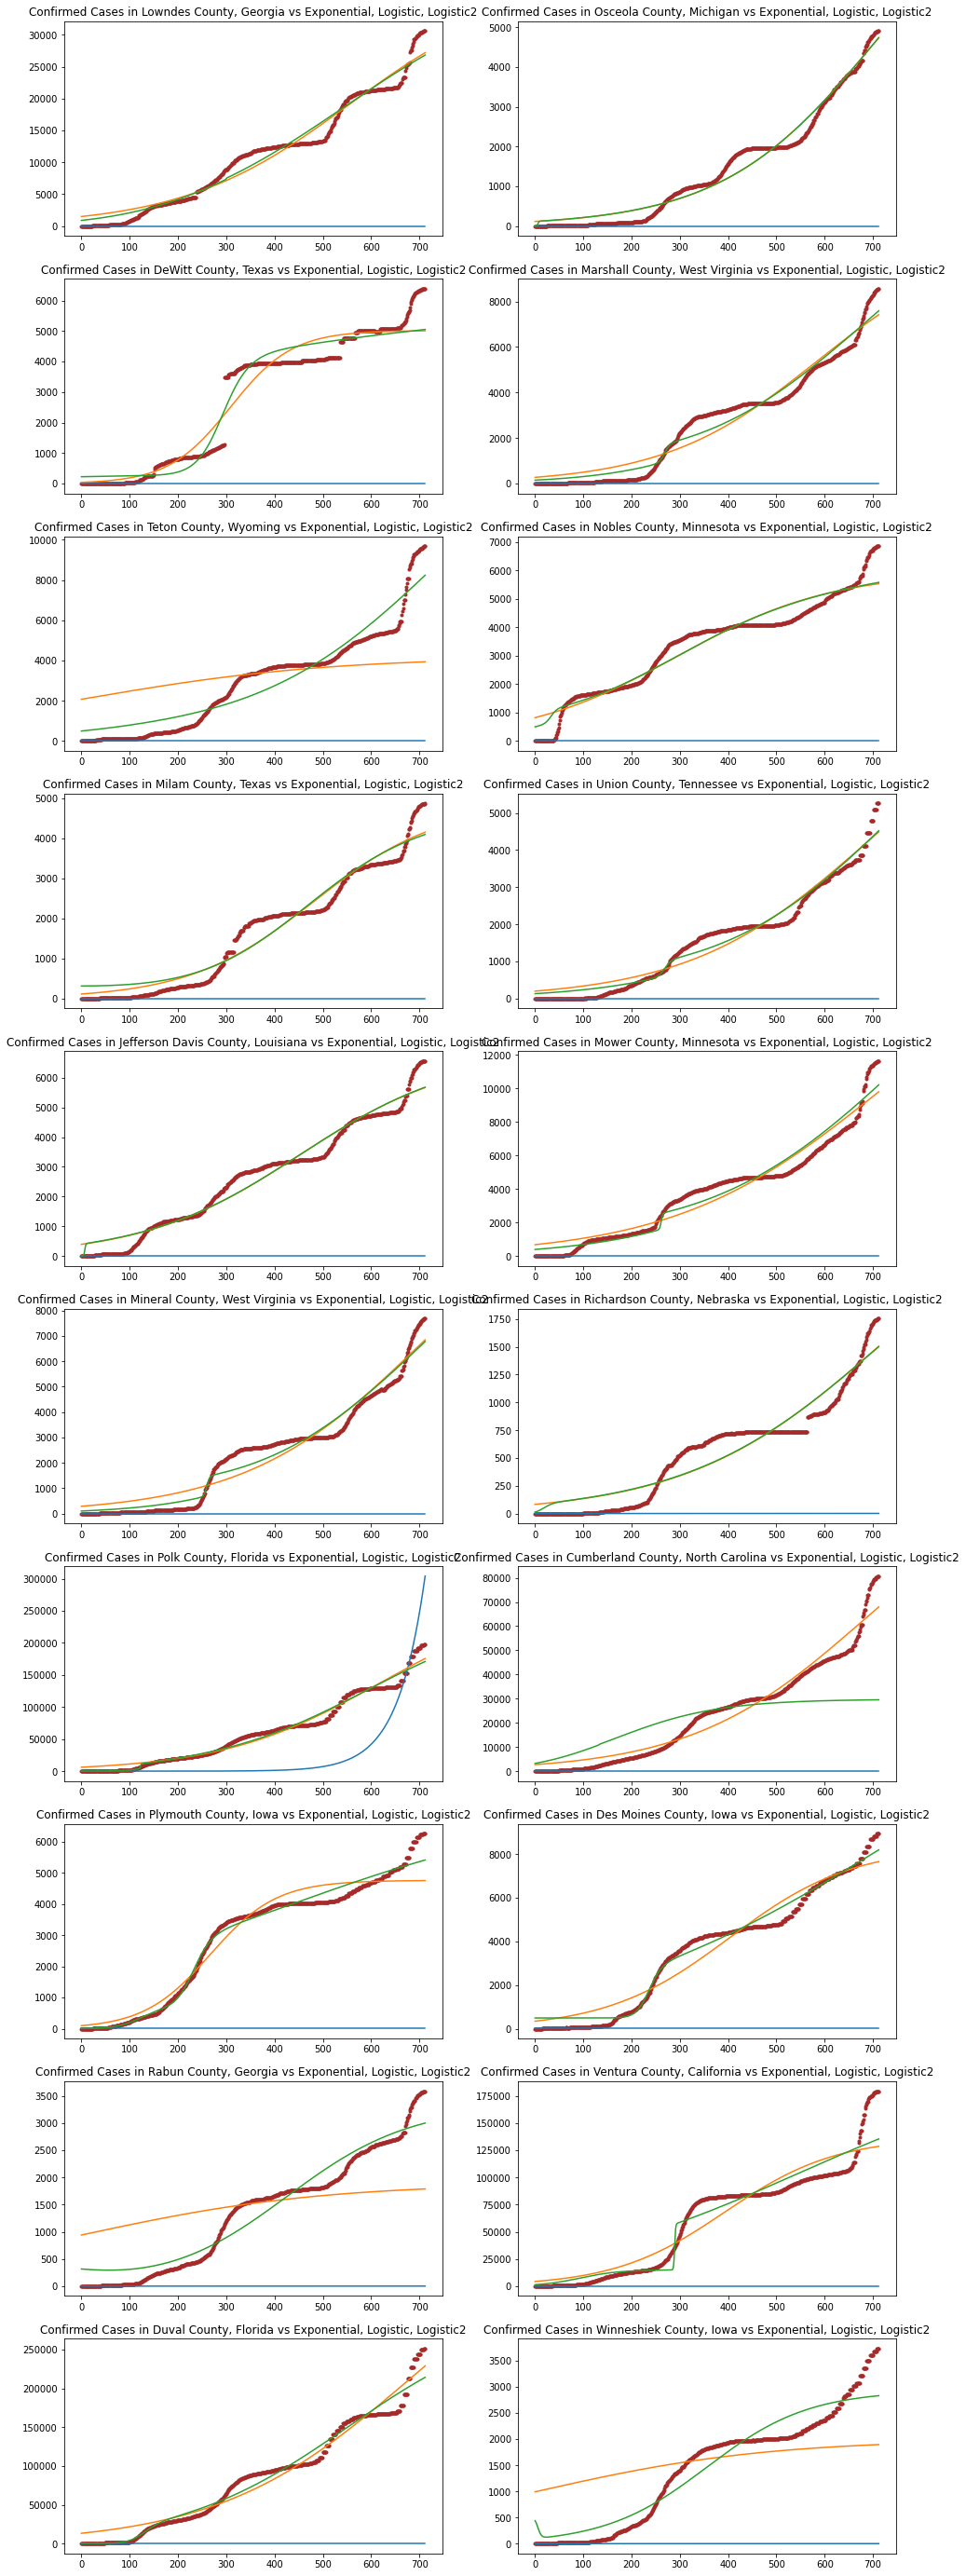

In [21]:
util.graph_examples(curves, ts_col_name, 
                    {"Exponential": curves["Exponential"],
                     "Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=non_fitting_mask,
                    num_to_pick=20)